# **Machine Learning**
## ***Project work on Painter style recognition***
### *50% of the project*

The aim of this project is to *recognize photos of paints* of three different artists:

- **Caravaggio**
- **Manet**
- **Van Gogh** 

## *Preliminary settings*

In [ ]:
## useful imports

import os
from google.colab import drive
import gdown

import numpy as np
import PIL.Image
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential, Model, save_model, load_model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras import backend as K
from keras import applications
from keras import optimizers

from keras.utils.vis_utils import plot_model

In [ ]:
# mounting drive and changing path

drive.mount('/content/drive')
%cd drive/MyDrive/29/data/

# path check
!pwd

Mounted at /content/drive
/content/drive/MyDrive/Group28_ML/data
/content/drive/MyDrive/Group28_ML/data


## *The collected dataset*

The first fundamental step is **dataset building**. The purpose is covering as much as possible the artistic productions of the involved painters, considering images containing frames, backgrounds, watermarks, texts, occlusions and characterized by different angles. To do that Internet is the best tool, along with a smart way through which searching the right photos. We mix the results given by:
- "handmade" search
- search realized by a smart Google Images crawler

Then we make a careful selection, trying to delete:
- images too small (under the estimated resolution of test set images)
- images whose quality is very low
- copies of exactly the same images
- *wrong* images because representing works not painted by Caravaggio, Manet or Van Gogh

The aim is obtaining only *useful* photos so that the training phase is not going to be problematic.

Given that the samples found online characterized by over imposed texts are not so many and variegate, creating new *custom* samples with these characteristics can be very important to ensure generalization. This is the reason why we use a very easy and smart online tool, whose name is *Canva*, to artificially augment data by creating new photos with particular over imposed elements: texts of different colors, sizes and fonts, small forms and so on. The number of custom samples is the same for each artist to guarantee the same 'treatment' during training phase for each class.

The final result is represented by six groups of images, two for each considered class. These groups are collected in folders named as follows:

- CARAVAGGIO, MANET, VANGOGH: which contain photos found on the Internet
- CARAVAGGIO_CANVA, MANET_CANVA, VANGOGH_CANVA: which contain photos modified using Canva

In [ ]:
# The following function returns the list of folders contained in a parent folder

def listdirs(path):
    return [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]


In [ ]:
main_folder = 'full/' # this is the folder containing the dataset

# list of each sub-folder
for directory in listdirs(main_folder):
    num_samples = len([entry for entry in os.listdir(main_folder +directory) if os.path.isfile(os.path.join(main_folder +directory, entry))])
    print(directory +' has ' +str(num_samples) +' items')


CARAVAGGIO_CANVA has 56 items
MANET_CANVA has 56 items
VANGOGH_CANVA has 56 items
CARAVAGGIO has 1749 items
MANET has 2318 items
VANGOGH has 4536 items


##Show some examples

In [ ]:
folder = 'MANET/' # folder of which you want to visualize samples
limit = len([entry for entry in os.listdir(main_folder +folder) if os.path.isfile(os.path.join(main_folder +folder, entry))])

import os

list_images = []
for filename in os.listdir(main_folder +folder):
  list_images.append(filename)

print(list_images)
i = 0

['MANET_782.jpg', 'MANET_990.jpg', 'MANET_417.jpg', 'MANET_1832.jpg', 'MANET_1456.jpg', 'MANET_701.jpg', 'MANET_12.jpg', 'MANET_512.jpg', 'MANET_1940.jpg', 'MANET_1639.jpg', 'MANET_579.jpg', 'MANET_2093.jpg', 'MANET_68.jpg', 'MANET_1267.jpg', 'MANET_1690.jpg', 'MANET_1539.jpg', 'MANET_179.jpg', 'MANET_1415.jpg', 'MANET_1750.jpg', 'MANET_1695.jpg', 'MANET_1992.jpg', 'MANET_1954.jpg', 'MANET_437.jpg', 'MANET_2290.jpg', 'MANET_1079.jpg', 'MANET_2181.jpg', 'MANET_145.jpg', 'MANET_1217.jpg', 'MANET_706.jpg', 'MANET_2019.jpg', 'MANET_386.jpg', 'MANET_40.jpg', 'MANET_924.jpg', 'MANET_1049.jpg', 'MANET_1546.jpg', 'MANET_2100.jpg', 'MANET_2315.jpg', 'MANET_1945.jpg', 'MANET_696.jpg', 'MANET_1682.jpg', 'MANET_1354.jpg', 'MANET_867.jpg', 'MANET_961.jpg', 'MANET_1163.jpg', 'MANET_464.jpg', 'MANET_225.jpg', 'MANET_385.jpg', 'MANET_1310.jpg', 'MANET_902.jpg', 'MANET_1427.jpg', 'MANET_1307.jpg', 'MANET_2033.jpg', 'MANET_2001.jpg', 'MANET_949.jpg', 'MANET_872.jpg', 'MANET_1643.jpg', 'MANET_58.jpg', 'M

MANET_417.jpg


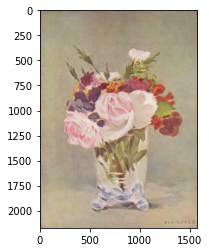

In [ ]:
if(i < limit):
  plt.imshow(PIL.Image.open(main_folder +folder +str(list_images[i])))
  print(list_images[i])
  #print(i)
  i = i + 1
else:
  print("You have scrolled through all the photos: re-initialize i=0 if you want to see them again")


##*The code of the preliminary NOT TRAINED network*

The technique we are going to use is **transfer learning** followed by **fine tuning**.

After testing several pre-trained networks over the collected dataset (and making the right changes to it in the light of the obtained results), we choose to use InceptionResNetV2 as base model. In fact, it is the network which gives us the best accuracy.

Obviously, it is needed to at least substitute the last dense layer (which counts 1000 neurons because realized to work with ImageNet) with a new output layer in order to match the number of classes of our problem (equals to 3).

In [ ]:
# import of InceptionResNetV2: a deep network pre-trained on ImageNet
from keras.applications.inception_resnet_v2 import InceptionResNetV2

model_name = 'InceptionResNetV2' # useful for saving weights and logs
base_model = applications.inception_resnet_v2.InceptionResNetV2(weights='imagenet', include_top=False, pooling='avg')

base_model.summary() # list of all InceptionResNetV2 layers


x = base_model.output 
predictions = Dense(units=3, activation='softmax')(x) 
model = Model(base_model.input, predictions)

219070464/219055592 [==============================] - 3s 0us/step
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)  